<a href="https://colab.research.google.com/github/Devaraj-D/Naan_muthalvan/blob/main/Diabetes_prediction_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # to plot charts
from collections import Counter
import os

# Modeling Libraries
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split



In [ ]:
# Import dataset
df = pd.read_csv("/bin/X11/diabetes.csv")
# Get familier with dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Show top 5 rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Explore missing values
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
# Correcting missing values in blood pressure
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean()) # There are 35 records with 0 BloodPressure in dataset
# Correcting missing values in BMI
df['BMI'] = df['BMI'].replace(0, df['BMI'].median())
# Correct missing values in Insulin and SkinThickness

df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].median())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].median())

# Review dataset statistics
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
def detect_outliers(df,n,features):
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

# detect outliers from numeric features
outliers_to_drop = detect_outliers(df, 2 ,["Pregnancies", 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'SkinThickness', 'Insulin', 'Age'])

In [ ]:
df.drop(df.loc[outliers_to_drop].index, inplace=True)
print(df)


In [ ]:
# Data Transformation
q  = QuantileTransformer()
X = q.fit_transform(df)
transformedDF = q.transform(X)
transformedDF = pd.DataFrame(X)
transformedDF.columns =['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
# Show top 5 rows
transformedDF.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.747718,0.810300,0.516949,0.801825,0.000000,0.591265,0.750978,0.889831,1.0
1,0.232725,0.097784,0.336375,0.644720,0.000000,0.227510,0.475880,0.558670,0.0
2,0.863755,0.956975,0.279009,0.000000,0.000000,0.091917,0.782269,0.585398,1.0
3,0.232725,0.131030,0.336375,0.505867,0.662973,0.298566,0.106258,0.000000,0.0
4,0.000000,0.721643,0.050847,0.801825,0.834420,0.926988,0.997392,0.606258,1.0


In [ ]:
features = df.drop(["Outcome"], axis=1)
labels = df["Outcome"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)

In [ ]:
def evaluate_model(models):
    """
    Takes a list of models and returns chart of cross validation scores using mean accuracy
    """

    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits = 10)

    result = []
    for model in models :
        result.append(cross_val_score(estimator = model, X = x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in result:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Models":[
            "LogisticRegression",
            "DecisionTreeClassifier",
            "AdaBoostClassifier",
            "SVC",
            "RandomForestClassifier",
            "GradientBoostingClassifier",
            "KNeighborsClassifier"
        ]
    })

    # Generate chart
    bar = sns.barplot(x = "CrossValMeans", y = "Models", data = result_df, orient = "h")
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross validation scores")
    return result_df

,CrossValMeans,CrossValerrors,Models
0,0.770964,0.058524,LogisticRegression
1,0.707687,0.065109,DecisionTreeClassifier
2,0.717016,0.061262,AdaBoostClassifier
3,0.761670,0.033724,SVC
4,0.759748,0.055512,RandomForestClassifier
5,0.748532,0.065303,GradientBoostingClassifier
6,0.746506,0.054171,KNeighborsClassifier


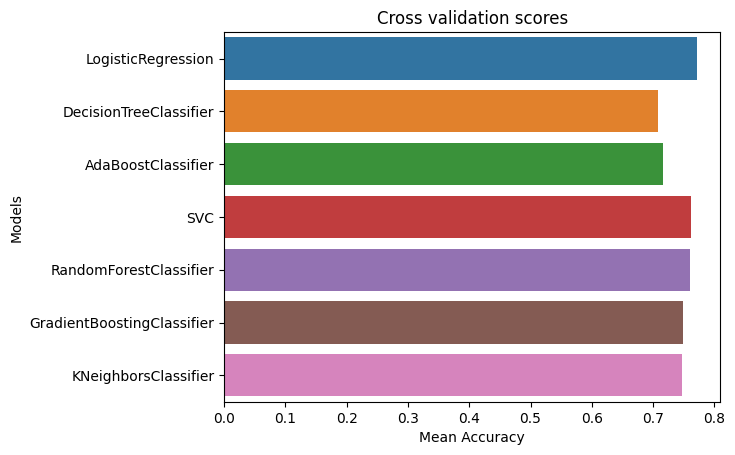

In [ ]:
# Modeling step Test differents algorithms
random_state = 30
models = [
    LogisticRegression(random_state = random_state, solver='liblinear'),
    DecisionTreeClassifier(random_state = random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.2),
    SVC(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    GradientBoostingClassifier(random_state = random_state),
    KNeighborsClassifier(),
]
evaluate_model(models)

In [ ]:
# Import libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
def analyze_grid_result(grid_result):
    '''
    Analysis of GridCV result and predicting with test dataset
    Show classification report at last
    '''
    # Best parameters and accuracy
    print("Tuned hyperparameters: (best parameters) ", grid_result.best_params_)
    print("Accuracy :", grid_result.best_score_)

    means = grid_result.cv_results_["mean_test_score"]
    stds = grid_result.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, grid_result.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    y_true, y_pred = y_test, grid_result.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
# Define models and parameters for LogisticRegression
model = LogisticRegression(solver='liblinear')
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# Define grid search
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = StratifiedKFold(n_splits = 50, random_state = 1, shuffle = True)
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = cv, scoring = 'accuracy', error_score = 0)
logi_result = grid_search.fit(x_train, y_train)
# Logistic Regression Hyperparameter Result
analyze_grid_result(logi_result)

Tuned hyperparameters: (best parameters)  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.774909090909091
0.773 (+/-0.241) for {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.773 (+/-0.241) for {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.773 (+/-0.241) for {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.775 (+/-0.226) for {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.773 (+/-0.240) for {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.773 (+/-0.224) for {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.773 (+/-0.242) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.720 (+/-0.225) for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.764 (+/-0.245) for {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.687 (+/-0.256) for {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Detailed classification report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       147
           1     

In [ ]:
# Test predictions
y_pred = logi_result.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       147
           1       0.74      0.58      0.65        84

    accuracy                           0.77       231
   macro avg       0.77      0.73      0.74       231
weighted avg       0.77      0.77      0.77       231



In [ ]:
x_test['pred'] = y_pred
print(x_test)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
353            1       90             62             12       43  27.2   
236            7      181             84             21      192  35.9   
323           13      152             90             33       29  26.8   
98             6       93             50             30       64  28.7   
701            6      125             78             31        0  27.6   
..           ...      ...            ...            ...      ...   ...   
188            8      109             76             39      114  27.9   
351            4      137             84              0        0  31.2   
120            0      162             76             56      100  53.2   
108            3       83             58             31       18  34.3   
616            6      117             96              0        0  28.7   

     DiabetesPedigreeFunction  Age  pred  
353                     0.580   24     0  
236                     0

# New Section